In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
# Add the parent directory to the path to import our modules
sys.path.append('..')

In [3]:
# Import our recommendation system modules
from src.data_preprocessing import DataPreprocessor
from src.content_based_filtering import ContentBasedRecommender
from src.collaborative_filtering import CollaborativeFilteringRecommender
from src.sentiment_based_filtering import SentimentBasedRecommender
from src.hybrid_recommender import HybridRecommender

In [4]:
# Set up matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [5]:
# Create sample data
def create_sample_data():
    # """Create sample data for demonstration purposes."""
    
    # Create sample products
    np.random.seed(42)
    n_products = 100
    
    product_ids = [f"P{i:03d}" for i in range(1, n_products + 1)]
    categories = ['Electronics', 'Clothing', 'Home', 'Books', 'Sports']
    
    products_data = {
        'product_id': product_ids,
        'name': [f"Product {i}" for i in range(1, n_products + 1)],
        'category': np.random.choice(categories, n_products),
        'price': np.random.uniform(10, 200, n_products).round(2),
        'description': [
            f"This is product {i} with various features and specifications. " +
            f"It belongs to the {cat} category and has good quality."
            for i, cat in zip(range(1, n_products + 1), np.random.choice(categories, n_products))
        ],
        'brand': np.random.choice(['BrandA', 'BrandB', 'BrandC', 'BrandD', 'BrandE'], n_products),
        'in_stock': np.random.choice([True, False], n_products, p=[0.8, 0.2])
    }
    
    products_df = pd.DataFrame(products_data)
    
    # Create sample users
    n_users = 50
    user_ids = [f"U{i:03d}" for i in range(1, n_users + 1)]
    
    users_data = {
        'user_id': user_ids,
        'name': [f"User {i}" for i in range(1, n_users + 1)],
        'age': np.random.randint(18, 70, n_users),
        'gender': np.random.choice(['M', 'F', 'Other'], n_users),
    }
    
    users_df = pd.DataFrame(users_data)
    
    # Create sample interactions
    n_interactions = 1000
    
    interactions_data = {
        'user_id': np.random.choice(user_ids, n_interactions),
        'product_id': np.random.choice(product_ids, n_interactions),
        'rating': np.random.randint(1, 6, n_interactions),
        'timestamp': pd.date_range(start='2023-01-01', periods=n_interactions, freq='H')
    }
    
    interactions_df = pd.DataFrame(interactions_data)
    
    # Create sample reviews
    n_reviews = 500
    
    positive_sentiments = [
        "I love this product! It's amazing.",
        "Great quality and value for money.",
        "Exactly what I was looking for.",
        "Exceeded my expectations.",
        "Would definitely recommend to others.",
        "Great Work."
    ]
    
    negative_sentiments = [
        "Not worth the price.",
        "Disappointed with the quality.",
        "Broke after a few uses.",
        "Doesn't match the description.",
        "Would not recommend."
    ]
    
    neutral_sentiments = [
        "It's okay, nothing special.",
        "Does the job but could be better.",
        "Average product for the price.",
        "Not bad, not great either.",
        "Meets basic expectations."
    ]
    
    reviews_data = {
        'review_id': [f"R{i:03d}" for i in range(1, n_reviews + 1)],
        'user_id': np.random.choice(user_ids, n_reviews),
        'product_id': np.random.choice(product_ids, n_reviews),
        'rating': np.random.randint(1, 6, n_reviews),
        'timestamp': pd.date_range(start='2023-01-01', periods=n_reviews, freq='D')
    }
    
    # Generate review text based on rating
    review_texts = []
    for rating in reviews_data['rating']:
        if rating >= 4:
            review_texts.append(np.random.choice(positive_sentiments))
        elif rating <= 2:
            review_texts.append(np.random.choice(negative_sentiments))
        else:
            review_texts.append(np.random.choice(neutral_sentiments))
    
    reviews_data['review_text'] = review_texts
    
    reviews_df = pd.DataFrame(reviews_data)
    
    # Save the data to CSV files
    os.makedirs('../data', exist_ok=True)
    
    products_df.to_csv('../data/sample_products.csv', index=False)
    users_df.to_csv('../data/sample_users.csv', index=False)
    interactions_df.to_csv('../data/sample_interactions.csv', index=False)
    reviews_df.to_csv('../data/sample_reviews.csv', index=False)
    
    return products_df, users_df, interactions_df, reviews_df

In [6]:
# Create and load sample data
products_df, users_df, interactions_df, reviews_df = create_sample_data()

/tmp/ipykernel_5082/539214317.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=n_interactions, freq='H')


In [7]:
print("Sample data created and saved to the data directory.")
print(f"Number of products: {len(products_df)}")
print(f"Number of users: {len(users_df)}")
print(f"Number of interactions: {len(interactions_df)}")
print(f"Number of reviews: {len(reviews_df)}")

Sample data created and saved to the data directory.
Number of products: 100
Number of users: 50
Number of interactions: 1000
Number of reviews: 500


In [8]:
# Display sample data
print("\nSample products:")
print(products_df.head())


Sample products:
  product_id       name category   price  \
0       P001  Product 1    Books  183.84   
1       P002  Product 2   Sports  171.51   
2       P003  Product 3     Home   95.40   
3       P004  Product 4   Sports   28.13   
4       P005  Product 5   Sports   80.46   

                                         description   brand  in_stock  
0  This is product 1 with various features and sp...  BrandB      True  
1  This is product 2 with various features and sp...  BrandA      True  
2  This is product 3 with various features and sp...  BrandA      True  
3  This is product 4 with various features and sp...  BrandA     False  
4  This is product 5 with various features and sp...  BrandC      True  


In [9]:
print("\nSample users:")
print(users_df.head())


Sample users:
  user_id    name  age gender
0    U001  User 1   23      M
1    U002  User 2   48      M
2    U003  User 3   36      F
3    U004  User 4   61      F
4    U005  User 5   56  Other


In [10]:
print("\nSample interactions:")
print(interactions_df.head())


Sample interactions:
  user_id product_id  rating           timestamp
0    U011       P053       5 2023-01-01 00:00:00
1    U021       P030       4 2023-01-01 01:00:00
2    U026       P039       1 2023-01-01 02:00:00
3    U025       P031       5 2023-01-01 03:00:00
4    U022       P082       5 2023-01-01 04:00:00


In [11]:
print("\nSample reviews:")
print(reviews_df.head())


Sample reviews:
  review_id user_id product_id  rating  timestamp  \
0      R001    U024       P053       5 2023-01-01   
1      R002    U015       P023       4 2023-01-02   
2      R003    U022       P069       2 2023-01-03   
3      R004    U030       P095       1 2023-01-04   
4      R005    U004       P053       1 2023-01-05   

                          review_text  
0                         Great Work.  
1  Great quality and value for money.  
2                Not worth the price.  
3                Would not recommend.  
4      Disappointed with the quality.  


In [12]:
# Data Preprocessing
print("\n--- Data Preprocessing ---")
preprocessor = DataPreprocessor(data_dir='../data')
preprocessor.load_data(
    products_file='sample_products.csv',
    users_file='sample_users.csv',
    interactions_file='sample_interactions.csv',
    reviews_file='sample_reviews.csv'
)
preprocessor.clean_data()


--- Data Preprocessing ---


/home/masubhaat/ML/recommendation_system/notebook/../src/data_preprocessing.py:128: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.products_df[col].fillna(self.products_df[col].mean(), inplace=True)
/home/masubhaat/ML/recommendation_system/notebook/../src/data_preprocessing.py:131: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whic

In [13]:
# Extract content features
print("\nExtracting content features...")
content_features = preprocessor.extract_content_features(
    text_columns=['description'],
    categorical_columns=['category', 'brand'],
    numerical_columns=['price']
)
print(f"Content features shape: {content_features.shape}")


Extracting content features...
Content features shape: (100, 32)


In [14]:
# Prepare collaborative data
print("\nPreparing collaborative data...")
collaborative_data = preprocessor.prepare_collaborative_data(min_interactions=2)
print(f"Collaborative data shape: {collaborative_data.shape}")


Preparing collaborative data...
Collaborative data shape: (909, 6)


In [15]:
# Prepare sentiment data
print("\nPreparing sentiment data...")
sentiment_data = preprocessor.prepare_sentiment_data()
print(f"Sentiment data shape: {sentiment_data.shape}")


Preparing sentiment data...
Sentiment data shape: (500, 7)


In [16]:
# These should be ONLY your engineered/processed numeric features
columns_to_use = [
    'price_scaled',
    'description_tfidf_0', 'description_tfidf_1', 'description_tfidf_2',
    'description_tfidf_3', 'description_tfidf_4', 'description_tfidf_5',
    'description_tfidf_6', 'description_tfidf_7', 'description_tfidf_8',
    'description_tfidf_9', 'description_tfidf_10', 'description_tfidf_11',
    'description_tfidf_12',
    'category_Books', 'category_Clothing', 'category_Sports',
    'category_Electronics', 'category_Home',
    'brand_BrandB', 'brand_BrandE', 'brand_BrandD', 'brand_BrandA', 'brand_BrandC',
    'in_stock'
]

In [17]:
# Content-Based Filtering
print("\n--- Content-Based Filtering ---")
content_recommender = ContentBasedRecommender()
content_recommender.fit(content_features, feature_columns=columns_to_use,id_column='product_id')


--- Content-Based Filtering ---


In [18]:
# Get similar products example
product_id = products_df['product_id'].iloc[0]
print(f"\nSimilar products to {product_id} ({products_df[products_df['product_id'] == product_id]['name'].values[0]}):")
similar_products = content_recommender.get_similar_products(product_id, n=5)
for pid, score in similar_products:
    product_name = products_df[products_df['product_id'] == pid]['name'].values[0]
    print(f"- {pid} ({product_name}): {score:.4f}")


Similar products to P001 (Product 1):
- P076 (Product 76): 0.9412
- P083 (Product 83): 0.9412
- P069 (Product 69): 0.9412
- P067 (Product 67): 0.9412
- P032 (Product 32): 0.9412


In [19]:
# Collaborative Filtering
print("\n--- Collaborative Filtering ---")
collaborative_recommender = CollaborativeFilteringRecommender()
collaborative_recommender.fit(interactions_df, method='item_based')


--- Collaborative Filtering ---


In [20]:
# Get recommendations for a user
user_id = users_df['user_id'].iloc[0]
print(f"\nRecommendations for user {user_id}:")
cf_recommendations = collaborative_recommender.recommend_for_user(user_id, n=5)
for pid, score in cf_recommendations:
    product_name = products_df[products_df['product_id'] == pid]['name'].values[0]
    print(f"- {pid} ({product_name}): {score:.4f}")


Recommendations for user U001:
- P077 (Product 77): 3.3141
- P043 (Product 43): 3.2734
- P083 (Product 83): 3.2411
- P096 (Product 96): 3.1945
- P016 (Product 16): 3.1372


In [21]:
# Sentiment-Based Filtering
print("\n--- Sentiment-Based Filtering ---")
sentiment_recommender = SentimentBasedRecommender()
sentiment_recommender.fit_vader_sentiment(reviews_df)


--- Sentiment-Based Filtering ---


In [22]:
# Get top products by sentiment
print("\nTop products by sentiment:")
sentiment_recommendations = sentiment_recommender.recommend_products(n=5, min_reviews=1)
for pid, score in sentiment_recommendations:
    product_name = products_df[products_df['product_id'] == pid]['name'].values[0]
    print(f"- {pid} ({product_name}): {score:.4f}")


Top products by sentiment:
- P008 (Product 8): 0.7386
- P037 (Product 37): 0.6478
- P031 (Product 31): 0.6249
- P019 (Product 19): 0.5892
- P001 (Product 1): 0.5656


In [23]:
# Hybrid Recommender
print("\n--- Hybrid Recommender ---")
hybrid_recommender = HybridRecommender()
hybrid_recommender.fit(
    products_df=products_df,
    interactions_df=interactions_df,
    reviews_df=reviews_df,
    collaborative_method='item_based',
    use_sentiment=True
)


--- Hybrid Recommender ---


In [24]:
# Set custom weights
hybrid_recommender.set_weights(content_weight=0.3, collaborative_weight=0.5, sentiment_weight=0.2)

In [25]:
# Get hybrid recommendations for a user
print(f"\nHybrid recommendations for user {user_id}:")
hybrid_recommendations = hybrid_recommender.recommend_for_user(user_id, n=5)
for pid, score in hybrid_recommendations:
    product_name = products_df[products_df['product_id'] == pid]['name'].values[0]
    print(f"- {pid} ({product_name}): {score:.4f}")


Hybrid recommendations for user U001:
- P043 (Product 43): 1.7493
- P077 (Product 77): 1.7328
- P083 (Product 83): 1.6213
- P096 (Product 96): 1.6078
- P018 (Product 18): 1.5501


In [26]:
# Evaluate the recommenders
print("\n--- Evaluation ---")
# Split interactions into train and test
train_interactions, test_interactions = preprocessor.split_data(interactions_df)


--- Evaluation ---


In [27]:
# After calling fit()
print("Similarity matrix type:", type(content_recommender.similarity_matrix))
print("Similarity matrix shape:", content_recommender.similarity_matrix.shape)

Similarity matrix type: <class 'numpy.ndarray'>
Similarity matrix shape: (100, 100)


In [28]:
# Evaluate content-based recommender
content_metrics = content_recommender.evaluate(test_interactions)
print("\nContent-based recommender metrics:")
for metric, value in content_metrics.items():
    print(f"- {metric}: {value:.4f}")


Content-based recommender metrics:
- precision@k: 0.0130
- recall@k: 0.0978
- f1_score: 0.0230
- k: 10.0000


In [29]:
# Evaluate collaborative recommender
collaborative_metrics = collaborative_recommender.evaluate(test_interactions)
print("\nCollaborative recommender metrics:")
for metric, value in collaborative_metrics.items():
    print(f"- {metric}: {value:.4f}")


Collaborative recommender metrics:
- precision@k: 0.0000
- recall@k: 0.0000
- ndcg@k: 0.0000
- f1_score: 0.0000
- k: 10.0000


In [30]:
# Evaluate sentiment recommender
sentiment_metrics = sentiment_recommender.evaluate(reviews_df)
print("\nSentiment recommender metrics:")
for metric, value in sentiment_metrics.items():
    print(f"- {metric}: {value:.4f}")


Sentiment recommender metrics:
- correlation: 0.6991
- accuracy: 0.7760
- precision: 0.7719
- recall: 0.6439
- f1_score: 0.7021


In [31]:
# Evaluate hybrid recommender
hybrid_metrics = hybrid_recommender.evaluate(test_interactions)
print("\nHybrid recommender metrics:")
for metric, value in hybrid_metrics.items():
    print(f"- {metric}: {value:.4f}")


Hybrid recommender metrics:
- precision@k: 0.0000
- recall@k: 0.0000
- ndcg@k: 0.0000
- f1_score: 0.0000
- k: 10.0000


In [32]:
# Visualize results
print("\n--- Visualization ---")
# Compare recommender performance
metrics = ['precision@k', 'recall@k', 'f1_score']
recommenders = ['Content-based', 'Collaborative', 'Hybrid']


--- Visualization ---


In [33]:
performance_data = {
    'Content-based': [content_metrics.get(m, 0) for m in metrics],
    'Collaborative': [collaborative_metrics.get(m, 0) for m in metrics],
    'Hybrid': [hybrid_metrics.get(m, 0) for m in metrics]
}

In [34]:
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.25

<Figure size 1000x600 with 0 Axes>

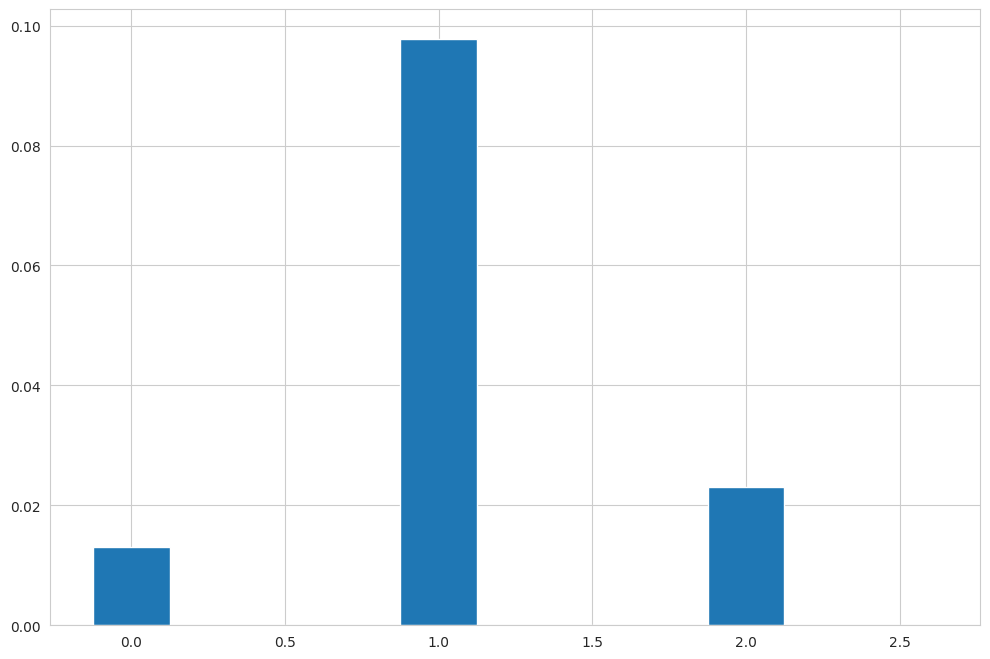

In [35]:
for i, (recommender, values) in enumerate(performance_data.items()):
    plt.bar(x + i*width, values, width, label=recommender)

In [36]:
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Recommender Performance Comparison')
plt.xticks(x + width, metrics)
plt.legend()
plt.tight_layout()
plt.savefig('../notebook/recommender_performance.png')
plt.close()

/tmp/ipykernel_5082/3762892982.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [37]:
print("Performance comparison chart saved to notebook/recommender_performance.png")

Performance comparison chart saved to notebook/recommender_performance.png


In [38]:
# Save the models
print("\n--- Saving Models ---")
content_recommender.save_model()
collaborative_recommender.save_model()
sentiment_recommender.save_model()
hybrid_recommender.save_model()


--- Saving Models ---


In [39]:
print("All models saved to the model directory.")

All models saved to the model directory.


In [40]:
print("\nRecommendation system demonstration complete!")


Recommendation system demonstration complete!
